

> Adicionar aspas

**Projeto de Transfer Learning em Python**
O projeto consiste em aplicar o método de Transfer Learning em uma rede de Deep Learning na linguagem Python no ambiente COLAB.  

✅ Resumo Técnico do Projeto
---
🎯 Objetivo:
---
Classificar imagens entre gatos e cachorros utilizando uma arquitetura de rede profunda pré-treinada (MobileNetV2) e refinar essa rede com Fine-Tuning para adaptar aos dados específicos.


🧠 Rede Profunda (Deep Network)
---
Usaremos MobileNetV2, que é uma rede neural convolucional profunda (CNN) com dezenas de camadas (mais de 150), originalmente treinada no dataset ImageNet (com mais de 1 milhão de imagens e 1.000 classes).


🔁 Transfer Learning
---
Transfer Learning = Reaproveitar o conhecimento aprendido em um grande dataset (ImageNet) para resolver um problema semelhante com um dataset menor (gatos e cachorros).



Como usamos no projeto:
Importamos o modelo MobileNetV2 pré-treinado

Removemos a "cabeça" original da rede (camada de saída com 1.000 classes)

Adicionamos nossas próprias camadas finais (para 1 classe binária: gato ou cachorro)

Treinamos essas novas camadas com nossos dados

# Transfer Learning com MobileNetV2 (com seus dados train_ds):

In [13]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
import tensorflow as tf
import tensorflow_datasets as tfds

from google.colab import files
from tensorflow.keras.preprocessing import image



In [2]:
# Carrega o dataset com splits para treino, validação e teste
(dataset_train, dataset_val, dataset_test), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True  # retorna tuplas (imagem, label)
)

In [3]:
# Pré-processamento e formatação dos dados
IMG_SIZE = 150

def format_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normaliza (0–1)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

batch_size = 32

train_ds = dataset_train.map(format_image).shuffle(1000).batch(batch_size)
val_ds = dataset_val.map(format_image).batch(batch_size)
test_ds = dataset_test.map(format_image).batch(batch_size)


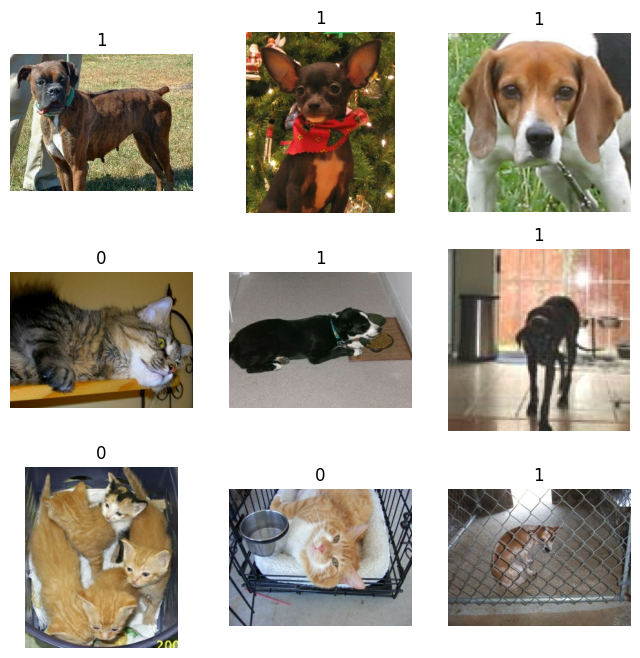

In [4]:
# Pega 9 imagens do dataset de treino e plota
plt.figure(figsize=(8, 8))
for i, (img, lbl) in enumerate(dataset_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(int(lbl))
    plt.axis('off')
plt.show()

In [5]:
# 3. Criando o modelo com MobileNetV2 (Transfer Learning)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # congela as camadas da base

/tmp/ipython-input-4169314068.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
# Camadas adicionais (topo da rede)
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # saída binária

model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 75, 75,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 75, 75,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 75, 75,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 75, 75,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 75, 75,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 75, 75,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 77, 77,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 38, 38,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 38, 38,    │      2,304 │ block_1_depthwis

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
# 4. Treinamento
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 282s 473ms/step - accuracy: 0.7973 - loss: 0.4309 - val_accuracy: 0.9445 - val_loss: 0.1470
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 303s 443ms/step - accuracy: 0.9347 - loss: 0.1602 - val_accuracy: 0.9549 - val_loss: 0.1218
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 268s 459ms/step - accuracy: 0.9477 - loss: 0.1292 - val_accuracy: 0.9592 - val_loss: 0.1124
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 274s 470ms/step - accuracy: 0.9534 - loss: 0.1202 - val_accuracy: 0.9609 - val_loss: 0.1062
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 311s 451ms/step - accuracy: 0.9563 - loss: 0.1106 - val_accuracy: 0.9617 - val_loss: 0.1028


In [8]:
# 5. Avaliação
loss, acc = model.evaluate(test_ds)
print(f'\n✅ Test accuracy: {acc:.2%}')

73/73 ━━━━━━━━━━━━━━━━━━━━ 29s 394ms/step - accuracy: 0.9669 - loss: 0.0900

✅ Test accuracy: 96.86%


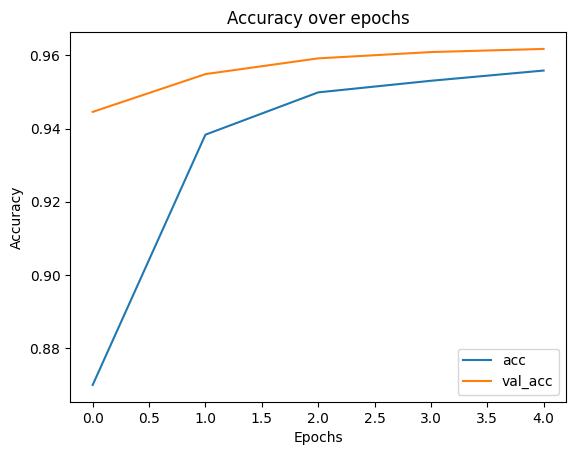

In [10]:
# 6. Curvas de treino
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

Saving x.jpg to x (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


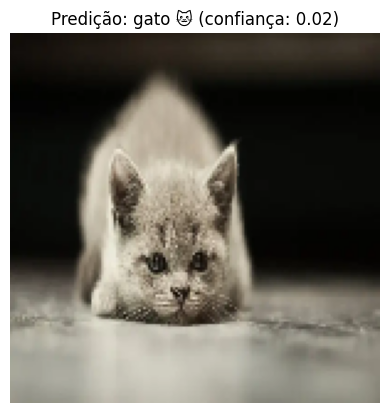

In [20]:
# 1️⃣ Upload da imagem pelo botão
uploaded = files.upload()

for nome_arquivo in uploaded.keys():
    # 2️⃣ Carrega e pré-processa a imagem
    caminho_imagem = nome_arquivo
    img = image.load_img(caminho_imagem, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # 3️⃣ Faz a predição com o modelo treinado
    predicao = model.predict(img_array)
    classe = 'cachorro 🐶' if predicao[0][0] > 0.5 else 'gato 🐱'
    conf = float(predicao[0][0])

    # 4️⃣ Mostra a imagem e resultado
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predição: {classe} (confiança: {conf:.2f})')
    plt.show()